In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ARIMAX/SARIMAX is provided through statsmodels' "tsa.statespace.sarimax"
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error


df = pd.read_csv('./data/final_data.csv')  # your annual dataset

df['total_sport_athelete'] = df['sport_num_female_athletes'] + df['sport_num_male_athletes']

df = df.drop(['sport_num_female_athletes','sport_num_male_athletes',
              'rank_country_year','total_gold_country_year','total_silver_country_year',
              'total_bronze_country_year','total_medal_country_year','total_athelete_country_year'],axis=1)

In [29]:
# this was even before i considered optimization. Here, I 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import optuna

# Load data
df = pd.read_csv('./data/final_data.csv')  # your annual dataset

df['total_sport_athelete'] = df['sport_num_female_athletes'] + df['sport_num_male_athletes']

df = df.drop(['sport_num_female_athletes','sport_num_male_athletes',
              'rank_country_year','total_gold_country_year','total_silver_country_year',
              'total_bronze_country_year','total_medal_country_year','total_athelete_country_year'],axis=1)

sport_data = df[df['Sport'] == 'Swimming']
us_data = sport_data[sport_data['NOC'] == 'United States']  	 	 	

data = pd.DataFrame({
    'Year': us_data['Year'],
    'Gold': us_data['sport_medal_gold'],
    'Silver': us_data['sport_medal_silver'],
    'Bronze': us_data['sport_medal_bronze'],
    'Games': us_data['num_games_sports_each_year'],
    'Host': us_data['host_status'],
    'FutureHost': us_data['future_host_status'],
    'Athletes': us_data['total_sport_athelete']
})


data = data.sort_values(by='Year')
years = data['Year'].values

data.set_index('Year', inplace=True)

data.index = pd.PeriodIndex(data.index, freq='Y')

data['Gold_lag'] = data['Gold'].shift(1)
data['Gold_lag2'] = data['Gold'].shift(2)
data['Gold_lag3'] = data['Gold'].shift(3)


data['Silver_lag'] = data['Silver'].shift(1)
data['Silver_lag2'] = data['Silver'].shift(2)
data['Silver_lag3'] = data['Silver'].shift(3)

data['Bronze_lag'] = data['Bronze'].shift(1)
data['Bronze_lag2'] = data['Bronze'].shift(2)
data['Bronze_lag3'] = data['Bronze'].shift(3)


# data['Winning_Ratio_lag2'] = data['Winning_Ratio'].shift(2)

data = data.fillna(0)
# data = data.dropna()

In [30]:
# Robust Objective Function for Optuna
def robust_objective(trial, y_train, X_train):
    # Suggest hyperparameters with constrained search space
    p = trial.suggest_int('p', 0, 10)
    d = trial.suggest_int('d', 0, 3)
    q = trial.suggest_int('q', 0, 10)
    
    try:
        # Create and fit the model
        model = SARIMAX(y_train, exog=X_train, order=(p, d, q),
                        enforce_stationarity=False, enforce_invertibility=False)
        result = model.fit(disp=False, maxiter=1000)
        
        # Predict on training data
        y_pred = result.get_forecast(steps=len(y_train), exog=X_train).predicted_mean
        
        # Calculate performance metrics
        mse = mean_squared_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        
        # Robust objective function
        if r2 < 0:
            return float('inf')
        
        # Minimize MSE while favoring higher R-squared
        objective_value = mse / (r2 + 1e-10)
        
        return objective_value
    
    except Exception as e:
        return float('inf')

# Tune SARIMAX Hyperparameters
def tune_sarimax(y_train, X_train):
    study = optuna.create_study(direction='minimize')
    
    def objective(trial):
        return robust_objective(trial, y_train, X_train)
    
    study.optimize(objective, n_trials=200)
    
    return study.best_params, study.best_value


In [31]:
# Define dependent and exogenous variables
y = data['Gold'].astype(float)

X = data[['Athletes', 'Host', 'Games', 'Gold_lag']].astype(float)

# Split data into training (80%) and testing (20%)
split_index = int(len(data) * 0.8)
y_train, y_test = y[:split_index], y[split_index:]
X_train, X_test = X[:split_index], X[split_index:]


In [32]:
# Tune hyperparameters
best_params, best_score = tune_sarimax(y_train, X_train)
print(f"Best parameters: {best_params}")
print(f"Best Score: {best_score}")


    # Final model with best parameters
final_model = SARIMAX(y_train, exog=X_train, 
                          order=(best_params['p'], best_params['d'], best_params['q']),
                          enforce_stationarity=False, enforce_invertibility=False)
final_result = final_model.fit(disp=False, maxiter=1000)

# Prediction
y_pred = final_result.forecast(steps=len(y_test), exog=X_test)

# Calculate errors
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

[I 2025-01-26 17:19:30,958] A new study created in memory with name: no-name-1ebc58ba-f03f-4d05-9d1f-dcc25ac9a645
[I 2025-01-26 17:19:31,324] Trial 0 finished with value: inf and parameters: {'p': 6, 'd': 2, 'q': 3}. Best is trial 0 with value: inf.
[I 2025-01-26 17:19:31,866] Trial 1 finished with value: inf and parameters: {'p': 7, 'd': 2, 'q': 3}. Best is trial 0 with value: inf.
[I 2025-01-26 17:19:32,382] Trial 2 finished with value: inf and parameters: {'p': 6, 'd': 3, 'q': 3}. Best is trial 0 with value: inf.
[I 2025-01-26 17:19:32,466] Trial 3 finished with value: inf and parameters: {'p': 3, 'd': 3, 'q': 2}. Best is trial 0 with value: inf.
[I 2025-01-26 17:19:32,766] Trial 4 finished with value: inf and parameters: {'p': 2, 'd': 0, 'q': 7}. Best is trial 0 with value: inf.
[I 2025-01-26 17:19:32,817] Trial 5 finished with value: inf and parameters: {'p': 0, 'd': 1, 'q': 4}. Best is trial 0 with value: inf.
/home/iambee/miniconda3/envs/gpu/lib/python3.12/site-packages/statsmod

Best parameters: {'p': 0, 'd': 0, 'q': 0}
Best Score: 135.4806147882525
MAE: 7.21
RMSE: 9.28
R-squared: -0.13


TypeError: float() argument must be a string or a real number, not 'Period'

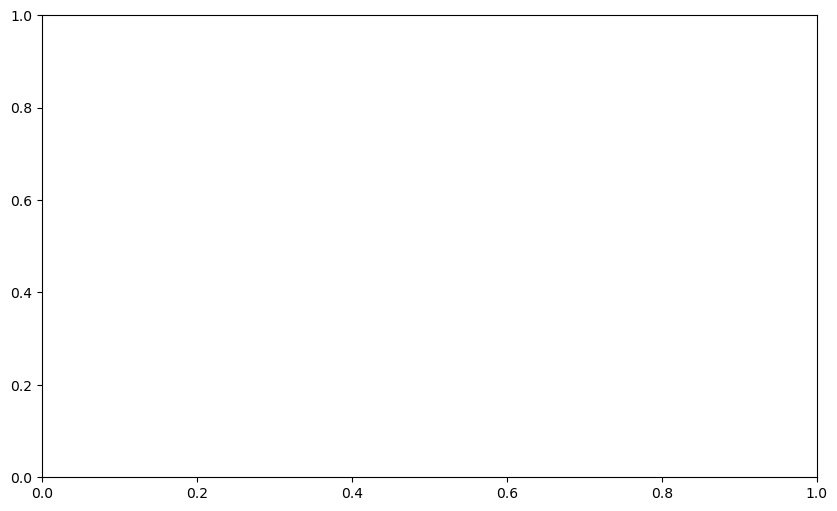

In [33]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y, label="Actual Medals", marker="o")
plt.plot(data.index[split_index:], y_pred, label="Predicted Medals", marker="o", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Medals")
plt.title("SARIMAX Model: Actual vs Predicted Medals")
plt.legend()
plt.grid()
plt.show()

/home/iambee/miniconda3/envs/gpu/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/iambee/miniconda3/envs/gpu/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/iambee/miniconda3/envs/gpu/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/iambee/miniconda3/envs/gpu/lib/python3.12/site-packages/statsmodels/base/m

Mean Absolute Error (MAE): 15.13
Root Mean Squared Error (RMSE): 18.50
R-squared: -3.48


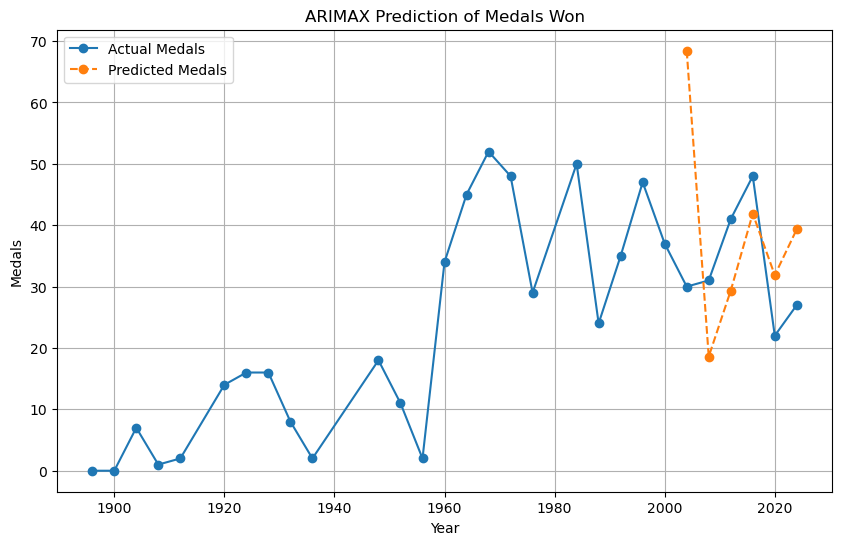

In [13]:
# Fit an ARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(7, 0, 8))  # Adjust p, d, q as needed
# model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1))  # Adjust p, d, q as needed
# model = SARIMAX(y_train, exog=X_train, order=(10, 0, 3))  # Adjust p, d, q as needed
result = model.fit(disp=False)

# Predict on test set
y_pred = result.forecast(steps=len(y_test), exog=X_test)

# Replace negative predictions with 0
y_pred = np.where(y_pred < 0, 0, y_pred)

# Round predictions to the nearest integer
# y_pred = np.round(y_pred).astype(int)

# Calculate errors
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared: {r2:.2f}")


# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(data['Year'], y, label="Actual Medals", marker="o")
plt.plot(data['Year'][split_index:], y_pred, label="Predicted Medals", marker="o", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Medals")
plt.title("ARIMAX Prediction of Medals Won")
plt.legend()
plt.grid()
plt.show()